In [3]:
import os
import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd
from os.path import join

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

import keras
import tensorflow
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, Bidirectional, Lambda, GRU, concatenate
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras import backend as K

import librosa
import kapre
#from kapre.time_frequency import Melspectrogram
#from kapre.utils import Normalization2D
#kapre.composed.get_melspectrogram_layer(input_shape=(44100, 1))
from kapre.composed import get_melspectrogram_layer, get_log_frequency_spectrogram_layer

import matplotlib.pyplot as plt
%matplotlib inline 
import scikitplot as skplt #install scikit-plot


In [4]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


#label the genres, map them into numbers
reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [5]:
#test the training array
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [6]:
#test the valid array
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


Electronic


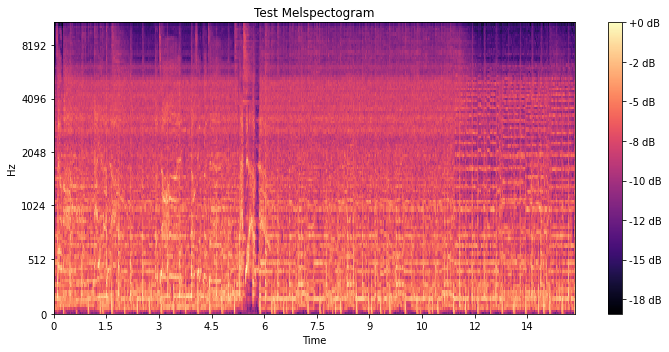

In [7]:
import librosa.display

#Test the spectrogram by specifying the genre saved in an array
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

In [8]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]
#print(n_features)

In [10]:
from keras import regularizers
import tensorflow as tf

nb_filters1=128  #16 
nb_filters2=128  #32 
nb_filters3=128  #64
nb_filters4=256    #64
nb_filters5=512     #64
ksize = 3 #previously (3, 1)
pool_size_1= 4 #previously (2,2) 
pool_size_2= 2 #(4,4)
pool_size_3 = 1 #(4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 128   #
EPOCH_COUNT = 50
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional layers, strides=1
    conv_1 = Conv1D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling1D(pool_size_1)(conv_1)

    conv_2 = Conv1D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling1D(pool_size_1)(conv_2)

    conv_3 = Conv1D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling1D(pool_size_1)(conv_3)
    
    conv_4 = Conv1D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling1D(pool_size_2)(conv_4)
    
    conv_5 = Conv1D(filters = nb_filters5, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling1D(pool_size_3)(conv_5)

    flatten1 = Flatten()(pool_5)

    #dense1 = Dense(64, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(flatten1)

    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)#(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)

#add the optimizers function for classification
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    
    print(model.summary())
    return model

In [9]:
# from keras import regularizers
# import tensorflow as tf

# nb_filters1=16 
# nb_filters2=32 
# nb_filters3=64
# nb_filters4=64
# nb_filters5=64
# ksize = (3,1)
# pool_size_1= (2,2) 
# pool_size_2= (4,4)
# pool_size_3 = (4,2)

# dropout_prob = 0.20
# dense_size1 = 128
# lstm_count = 64
# num_units = 120

# BATCH_SIZE = 64
# EPOCH_COUNT = 50
# L2_regularization = 0.001

# def conv_recurrent_model_build(model_input):
#     print('Building model...')
#     layer = model_input
    
#     ### Convolutional blocks
#     conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_1')(layer)
#     pool_1 = MaxPooling2D(pool_size_1)(conv_1)

#     conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_2')(pool_1)
#     pool_2 = MaxPooling2D(pool_size_1)(conv_2)

#     conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_3')(pool_2)
#     pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
#     conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_4')(pool_3)
#     pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
#     conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
#                       padding= 'valid', activation='relu', name='conv_5')(pool_4)
#     pool_5 = MaxPooling2D(pool_size_2)(conv_5)

#     flatten1 = Flatten()(pool_5)
#     ### Recurrent Block
    
#     # Pooling layer
#     pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
#     # Embedding layer

#     squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
# #     flatten2 = K.squeeze(pool_lstm1, axis = -1)
# #     dense1 = Dense(dense_size1)(flatten)
    
#     # Bidirectional GRU
#     lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
#     # Concat Output
#     concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
#     ## Softmax Output
#     output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
#     model_output = output
#     model = Model(model_input, model_output)
    
# #     opt = Adam(lr=0.001)
#     opt = tf.keras.optimizers.RMSprop(lr=0.0005)  # Optimizer
#     model.compile(
#             loss='sparse_categorical_crossentropy',
#             optimizer=opt,
#             metrics=['accuracy']
#         )
    
#     print(model.summary())
#     return model

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

#Train the model based on the previous cell, initialize the input to be fed into the model#Use Reduce function to decrease the learning rate
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    n_frames = x_train.shape[1]
    input_shape = (n_frames, n_features) #1
    model_input = Input(input_shape, name='input')

    model = conv_recurrent_model_build(model_input)
    
    checkpoint_callback = ModelCheckpoint('./1dcnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [12]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Visually Summarize history for accuracy
    plt.plot(history.history['accuracy'])  #accuracy/acc
    plt.plot(history.history['val_accuracy'])   #val_accuracy/val_acc
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Visually Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 640, 128)]        0         
                                                                 
 conv_1 (Conv1D)             (None, 638, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 159, 128)         0         
 )                                                               
                                                                 
 conv_2 (Conv1D)             (None, 157, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv_3 (Conv1D)             (None, 37, 128

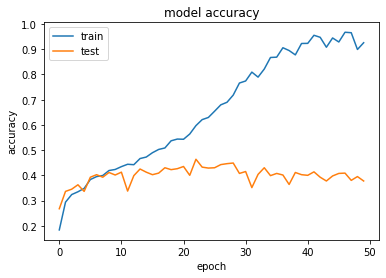

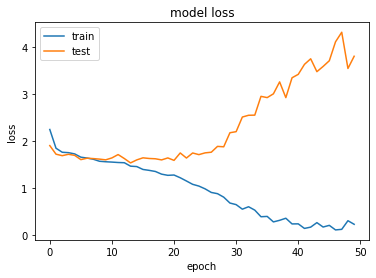

In [13]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)
show_summary_stats(history)

In [14]:
from sklearn.metrics import classification_report

#display classification report on training validation
#print(y_valid)
y_true = y_valid
y_pred = np.argmax(model.predict(X_valid), axis=-1)
#print(y_pred)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.39      0.50      0.44       100
 Experimental       0.19      0.11      0.14       100
         Folk       0.45      0.43      0.44       100
      Hip-Hop       0.51      0.56      0.54       100
 Instrumental       0.35      0.26      0.30       100
International       0.46      0.58      0.52       100
          Pop       0.17      0.23      0.19       100
         Rock       0.49      0.35      0.41       100

     accuracy                           0.38       800
    macro avg       0.38      0.38      0.37       800
 weighted avg       0.38      0.38      0.37       800



In [15]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.3775


In [47]:
from keras.models import load_model

weights_path = './1dcnn/weights.best.h5'
model = load_model(weights_path)

OSError: SavedModel file does not exist at: ./1dcnn/weights.best.h5\{saved_model.pbtxt|saved_model.pb}

In [16]:
#load the test array
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [17]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [18]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.004623813040644377


In [19]:
#Classification report for testing
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.46      0.41      0.43       100
 Experimental       0.25      0.14      0.18       100
         Folk       0.13      0.13      0.13       100
      Hip-Hop       0.60      0.75      0.66       100
 Instrumental       0.36      0.27      0.31       100
International       0.36      0.47      0.41       100
          Pop       0.22      0.33      0.26       100
         Rock       0.44      0.31      0.36       100

     accuracy                           0.35       800
    macro avg       0.35      0.35      0.34       800
 weighted avg       0.35      0.35      0.34       800



In [31]:
y_test = to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

ValueError: in user code:

    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1305, in test_step
        self.compiled_loss(
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "C:\Users\Lam Hoang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(256,) and logits.shape=(32, 8)


In [20]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[41  2  5 10  4 20 13  5]
 [17 14 19  4 15 13 14  4]
 [ 0 19 13  0 16 14 29  9]
 [10  0  1 75  0  6  7  1]
 [ 1 13 26  4 27  5 20  4]
 [ 5  3 18  6  0 47 10 11]
 [13  2 10 22  3 12 33  5]
 [ 3  4  9  5  9 12 27 31]]


In [21]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.35125


Text(91.68, 0.5, 'predicted label')

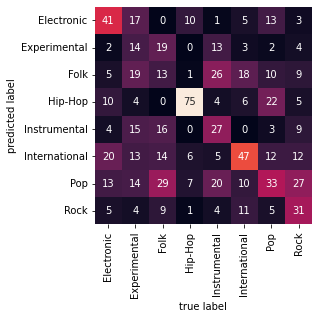

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label')